# Data Visualization Notebook

### Objectives

Answer business requirement 1:
* The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

### Inputs

* inputs/cherry_leaves_dataset/cherry_leaves_images/train
* inputs/cherry_leaves_dataset/cherry_leaves_images/test
* inputs/cherry_leaves_dataset/cherry_leaves_images/validation

### Outputs

+ Image shape embeddings pickle file
+ Mean and variability of images per label plot
+ Plot to distinguish contrast between images of healthy cherry leaves and images of cherry leaves that contain powdery mildew.
+ Generate code that answers business requirement 1 and can be used to build image montage on Streamlit dashboard.

# Set Data Directory

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### Set working directory

In [3]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspaces/mildew-detector')
print("Set 'mildew-detector' as the new current directory")

Set 'mildew-detector' as the new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

### Set input directories

+ Set train, validation and test paths

In [6]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry_leaves_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [8]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['healthy', 'powdery_mildew']


# Data visualization of images

### Image shape embeddings

+ Compute average images' size on train set.

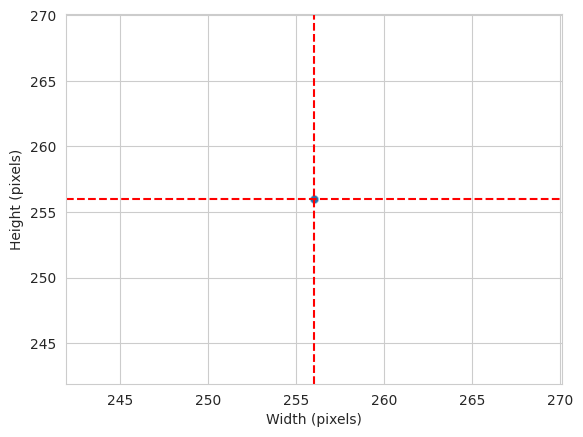

Width average: 256 
Height average: 256


In [9]:
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1) # image height
    dim2.append(d2) # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

+ Instead of the average image size of all images of the train set, I will apply 100 px * 100 px as the image_shape that is going to be used to train the model.
+ This will make pushing to Github smoother.

In [10]:
image_shape = (100, 100, 3)
image_shape

(100, 100, 3)

+ Save the image shape embeddings

In [11]:
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

### Average and variability of images per label

+ Function to load images, convert them into an array format, and resize them.

In [14]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label = 20):
  
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      # n_images_per_label: we set a limit, since it may take too much time
      if counter < n_images_per_label:
        
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

+ Execute the function above.

In [17]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                          n_images_per_label = 30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


+ Plot and save mean and variability of images per label

In [20]:
def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
  """
   The pseudo code for the function is:
  * Loop in all labels
  * Subset an array for given label
  * Calculate mean and standard deviation
  * Create a figure displaying mean and variability of images
  * Save image

  """

  for label_to_display in np.unique(y):
    sns.set_style("white")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='gray')

    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

==== Label healthy ====
Image Shape: (100, 100, 3)
==== Label powdery_mildew ====
Image Shape: (100, 100, 3)


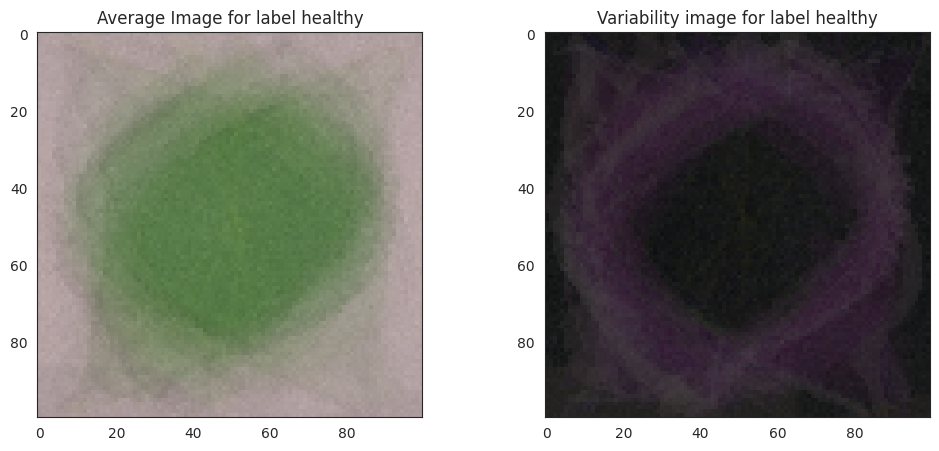

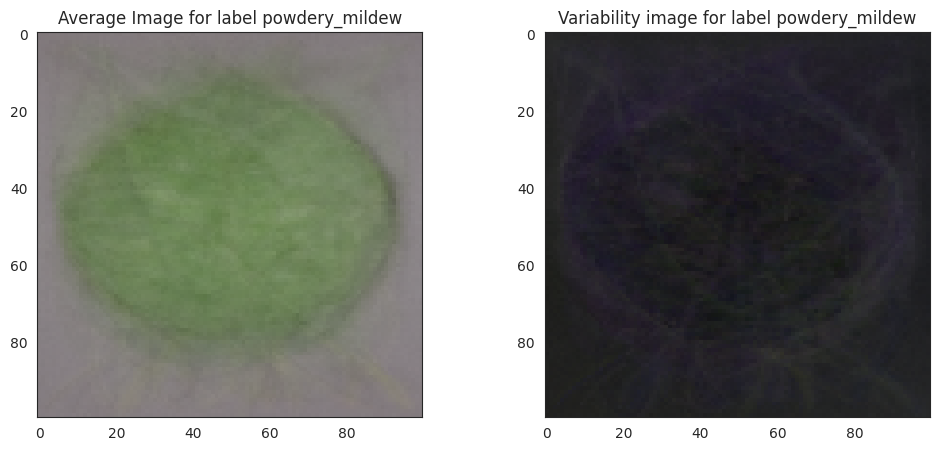

In [21]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)